run all cells, change parameters in last cell

In [ ]:
from enum import Enum
from math import sqrt, floor, ceil, log, exp
import random
from warnings import warn

import json
import matplotlib.pyplot as plt
import networkx as nx

# 1) Classes for nodes and edges

In [ ]:
class DataObject:

  def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)

class Level(Enum):
  MOLECULAR = 'molecular'
  MODULE = 'module'
  ORGANELLE = 'organelle'
  COMMUNITY = 'community'

class NetworkMap(DataObject):
  level = None
  nodes = []
  edges = []

  def __init__(self, level, nodes, edges):
    self.level = level
    self.nodes = nodes
    self.edges = edges

class NodeType(Enum):
  CIRCLE = 'circle'
  SQUARE = 'square'
  DIAMOND = 'diamond'

class Node(DataObject):
  nodeId = 0
  label = ''
  modelElementRef = ''
  dataRef = ''
  nodeType = NodeType.CIRCLE
  isSecondaryMetabolite = False
  size = 1
  color = 1
  x = 0
  y = 0
  connections = []
  degree = 0
  is_exchange_metabolite = False

  def __init__(self, nodeId, label, modelElementRef, dataRef, nodeType, x, y):
    self.nodeId = nodeId
    self.label = label
    self.modelElementRef = modelElementRef
    self.dataRef = dataRef
    self.nodeType = nodeType
    self.x = x
    self.y = y
    self.connections = []
    self.degree = 0

class EdgeType(Enum):
  UNDIRECTED = 'undirected'
  FORWARD = 'forward'
  REVERSIBLE = 'reversible'

class Edge(DataObject):
  edgeId = 0
  label = ''
  modelElementRef = ''
  dataRef = ''
  width = 1
  color = 1
  edgeType = EdgeType.UNDIRECTED
  flux = 0
  source = 0
  target = 0

  def __init__(self, edgeId, label, modelElementRef, dataRef, edgeType, flux, source, target):
    self.edgeId = edgeId
    self.label = label
    self.modelElementRef = modelElementRef
    self.dataRef = dataRef
    self.edgeType = edgeType
    self.flux = flux
    self.source = source
    self.target = target

class NodeCollection:
  nodes = {}
  length = 0
  nodeType = NodeType.CIRCLE
  degreeDistribution = []
  exchangeMetaboliteDistribution = []

  def __init__(self, nodes, nodeType, length, degreeDistribution, exchangeMetaboliteDistribution):
    self.nodes = nodes
    self.nodeType = nodeType
    self.length = length
    self.degreeDistribution = degreeDistribution
    self.exchangeMetaboliteDistribution = exchangeMetaboliteDistribution


# 2) Generating nodes

In [ ]:
def build_node_collections(node_collections):
  # current node id
  current_id = 0
  # current positions
  x = 0
  y = 0

  for collection in node_collections:
    for node_index in range(0, collection.length):

      label = 'node_' + str(current_id)
      modelElementRef = ''
      dataRef = ''

      new_node = Node(
          current_id,
          label,
          modelElementRef='',
          dataRef='',
          nodeType=collection.nodeType,
          x=x,
          y=y)

      new_node.degree = collection.degreeDistribution[node_index]
      exchangeMetaboliteDistribution = collection.exchangeMetaboliteDistribution[node_index]

      collection.nodes.update({current_id: new_node})

      current_id += 1

def generate_nodes(number_of_nodes, level):
  ## parameters and distributions
  # ratio of metabolites and reactions
  metabolite_node_fraction = 0.44
  number_of_metabolites = floor(number_of_nodes * (1-metabolite_node_fraction))
  number_of_reactions = floor(number_of_nodes * metabolite_node_fraction)

  # fraction of exchange metabolites among total metabolites
  exchange_metabolite_fraction = 0.28

  # probability distribution of node degrees (power law)
  # min degree == 2 --> metabolite nodes are fully connected
  metabolite_degrees = [deg for deg in range(2, 15)]
  metabolite_probability = [deg ** (-2.2) for deg in metabolite_degrees]
  # normalization of accumulated probabilities to 1
  metabolite_probability = [ prob / sum(metabolite_probability) for prob in metabolite_probability]
  metabolite_degree_distribution = random.choices(metabolite_degrees, metabolite_probability, k=number_of_metabolites)


  # probability distribution for reaction node degree
  reaction_degrees = [deg for deg in range(2, 16)]
  reaction_probability = [deg ** (-2.2) for deg in reaction_degrees]
  reaction_probability = [ prob / sum(reaction_probability) for prob in reaction_probability]
  reaction_degree_distribution = random.choices(reaction_degrees, reaction_probability, k=number_of_reactions)

  # probability distribution of exchange metabolites
  exchange_metabolite = [True, False]
  exchange_metabolite_fractions = [exchange_metabolite_fraction, 1-exchange_metabolite_fraction]
  exchange_metabolite_distribution = random.choices(exchange_metabolite, exchange_metabolite_fractions, k=number_of_metabolites)

  # probability distribution of module node degrees (power law)
  # min degree == 1
  module_degrees = [deg for deg in range(1, 10)]
  module_probability = [deg ** (-2.2) for deg in module_degrees]
  # normalization of accumulated probabilities to 1
  module_probability = [ prob / sum(module_probability) for prob in module_probability]
  module_degree_distribution = random.choices(module_degrees, module_probability, k=number_of_nodes)

  ## creating nodes
  node_collections = []

  if level == Level.MOLECULAR:
    # initialize node collections
    node_collections.extend(
        [NodeCollection({}, NodeType.CIRCLE, number_of_metabolites, metabolite_degree_distribution, exchange_metabolite_distribution),
        NodeCollection({}, NodeType.DIAMOND, number_of_reactions, reaction_degree_distribution, [False] * number_of_reactions),]
    )
  elif level == Level.MODULE or level == Level.ORGANELLE:
    node_collections.extend(
        [
            NodeCollection({}, NodeType.CIRCLE, number_of_nodes, module_degree_distribution, [False] * number_of_nodes)
        ]
    )

  build_node_collections(node_collections)

  return node_collections

# 3) Generate scale-free network of metabolite nodes

In [ ]:
def assign_edges_to_metabolites(metabolite_dict, reaction_dict, network_edges, metabolite_edges):

  metabolite_keys = metabolite_dict.keys()
  available_metabolites = set(metabolite_keys)

  reaction_keys = reaction_dict.keys()
  available_reactions = set(reaction_keys)

  assigned_exchange_metabolites = set()

  for metabolite_key in metabolite_keys:
    metabolite_obj = metabolite_dict[metabolite_key]

    # append edge to exchange reaction if exchange metabolite
    if metabolite_obj.is_exchange_metabolite and not (metabolite_key in assigned_exchange_metabolites):
      assigned_exchange_metabolites.add(metabolite_key)
      target_reaction = random.sample(available_reactions, 1)[0]
      available_reactions.remove(target_reaction)

      network_edges.append((metabolite_key, target_reaction))

    # if all edges assigned, continue
    if not metabolite_key in available_metabolites:
      continue

    # when metabolite is encountered all edges will be assigned, so remove from available list
    available_metabolites.remove(metabolite_key)

    # assign all edges
    while len(metabolite_obj.connections) < metabolite_obj.degree:

      # check if other metabolites are available
      if len(available_metabolites) == 0:
        break

      # get random edge target
      target_key = random.sample(available_metabolites, 1)[0]
      target_obj = metabolite_dict[target_key]

      # check whether target has free edges
      if len(target_obj.connections) == target_obj.degree:
        available_metabolites.remove(target_key)
        continue

      # register target id in source node object
      metabolite_obj.connections.append(target_key)

      # register source id in target node object
      target_obj.connections.append(metabolite_obj.nodeId)

      # append edge
      metabolite_edges.append((metabolite_key, target_key))

# 4) insert reaction nodes

In [ ]:
def assign_edges_to_reactions(reaction_obj, available_metabolite_edges, available_reactions, network_edges):
  # print('reactions: ' + str(len(available_reactions)))
  # print('mets: ' + str(len(available_metabolite_edges)))

  while len(reaction_obj.connections) < reaction_obj.degree:
    metabolite_edge = random.sample(available_metabolite_edges, 1)[0]
    available_metabolite_edges.remove(metabolite_edge)

    reaction_obj.connections.append(metabolite_edge[0])
    reaction_obj.connections.append(metabolite_edge[1])

    network_edges.append((metabolite_edge[0], reaction_obj.nodeId))
    network_edges.append((reaction_obj.nodeId, metabolite_edge[1]))

def add_internal_reactions(network_edges, metabolite_edges, reaction_dict, available_reactions):

  available_metabolite_edges = set(metabolite_edges)

  # assign all edges to one reaction
  while len(available_reactions) > 0:

    reaction = random.sample(available_reactions, 1)[0]
    available_reactions.remove(reaction)

    reaction_obj = reaction_dict[reaction]

    # reset metabolite edges
    if (reaction_obj.degree - len(reaction_obj.connections) > len(available_metabolite_edges)):
      available_metabolite_edges = set(metabolite_edges)

    assign_edges_to_reactions(reaction_obj, available_metabolite_edges, available_reactions, network_edges)

# 4.1) Build module/organelle networks

In [ ]:
def saturate_nodes(nodes, node_collection, available_keys):
  edges = []

  for key in nodes:

    # check if key is available (target removed because saturated)
    if key not in available_keys:
      continue

    # when metabolite is encountered all edges will be assigned, so remove from available list
    node_obj = node_collection.nodes[key]

    if len(nodes) > 1 or len(node_obj.connections) < node_obj.degree:
      available_keys.remove(key)

    # assign all edges as long as degree is not full and targets are available
    while len(node_obj.connections) < node_obj.degree and len(available_keys) > 0:

      # get random edge target
      target_key = random.sample(available_keys, 1)[0]

      if key == target_key:
        continue

      target_obj = node_collection.nodes[target_key]

      if len(target_obj.connections) == target_obj.degree and len(edges) < 1:
        target_obj.degree += 1

      # check whether target has free edges or is contained in input nodes otherwise remove
      # if len(target_obj.connections) == target_obj.degree and not target_key in nodes:
      #   available_keys.remove(target_key)
      #   continue

      # register target id in source node object
      node_obj.connections.append(target_key)
      # register source id in target node object
      target_obj.connections.append(node_obj.nodeId)

      # append edge
      edges.append((key, target_key))

    # if edges are empty, another run with extended node degrees is performed
    node_obj.degree += 1

  return edges

def iterative_saturation(nodes, node_collection, available_keys):
  edges = []

  counter = 0

  while counter < 5 and (len(available_keys) > 0 and len(edges) < 1):
    edges = saturate_nodes(nodes, node_collection, available_keys)
    counter += 1

  return edges

def calculate_free_degrees(nodes):

  degrees = set([node["deg"] for node in nodes])

  free_degrees = 0

  for degree in degrees:
    number_of_nodes_with_degree = len([node for node in nodes if node["deg"] == degree])

    if degree == 1:
      free_degrees -= number_of_nodes_with_degree
      continue

    free_degrees += number_of_nodes_with_degree * degree - 2 * (number_of_nodes_with_degree-1)

  free_degrees -= (len(degrees)-2) * 2
  print(free_degrees)

def assign_edges_to_nodes(node_collection):
  edges = []

  # get list of available nodes
  available_keys_dict = [{"deg": node_collection.nodes[node].degree, "id": node_collection.nodes[node].nodeId} for node in node_collection.nodes]
  available_keys_dict.sort(key=lambda x: x["deg"])

  calculate_free_degrees(available_keys_dict)

  print(available_keys_dict)

  # pick random seed node
  # seed = random.sample(available_keys, 1)[0]
  # # generate new edges for seed node
  # new_edges = saturate_nodes([seed], node_collection, available_keys)
  # edges.extend(new_edges)

  # while len(new_edges) > 0:
  #   # get target nodes
  #   new_targets = [edge[1] for edge in new_edges]

  #   # generate edges for target nodes
  #   new_edges = iterative_saturation(new_targets, node_collection, available_keys)

  #   edges.extend(new_edges)
  return edges


# 5) Build output json

In [ ]:
def build_output_json(level, network_edges, node_collections):

  node_objects = []
  edge_objects = []

  for collection in node_collections:
    for node in collection.nodes:
      node_object = collection.nodes[node]

      node_object.nodeType = node_object.nodeType.value
      del node_object.degree
      del node_object.connections

      node_objects.append(node_object)

  for edge_id, edge in enumerate(network_edges):
    edge_object = Edge(edge_id, "edge_" + str(edge_id), "", "", EdgeType.UNDIRECTED.value, 0, edge[0], edge[1])

    edge_objects.append(edge_object)

  print("number of nodes: " + str(len(node_objects)))
  print("number of edges: " + str(len(edge_objects)))

  network_map = NetworkMap(level.value, node_objects, edge_objects).toJSON()

  with open("network_n_" + str(len(node_objects)) + "_e_" + str(len(edge_objects)) + "_l_" + level.value +".json", "w") as outfile:
    outfile.write(network_map)

# 6) Build visualization

In [ ]:
def add_to_graph_from_dict(node_dict, graph):
  for node in node_dict:
    node_obj = node_dict[node]
    graph.add_node(node_obj.nodeId, pos=(node_obj.x,node_obj.y))

def build_graph(network_edges, node_collections):
  graph = nx.Graph()

  for node_collection in node_collections:
    add_to_graph_from_dict(node_collection.nodes, graph)

  graph.add_edges_from(network_edges)

  # print("Graph is connected: " + str(nx.is_connected(graph)))

  return graph

def draw_graph(graph, node_collections):

  fig, ax = plt.subplots()

  # pos = nx.get_node_attributes(graph, 'pos')
  pos = nx.spring_layout(graph, k=10)
  # pos = nx.random_layout(graph)

  for node_collection in node_collections:
    shape = 'o'

    if node_collection.nodeType == NodeType.DIAMOND:
      shape = 'd'

    add_to_graph_from_dict(node_collection.nodes, graph)
    nx.draw_networkx_nodes(graph, nodelist=list(node_collection.nodes.keys()), pos=pos, node_shape=shape)

  nx.draw_networkx_edges(graph, pos=pos)
  nx.draw_networkx_labels(graph, pos=pos)
  plt.show()

# 7) Compose everything

In [ ]:
def build_network_layout(node_number, level):

  node_collections = []
  node_collections = generate_nodes(node_number, level)
  network_edges = []
  graph = None

  if level == Level.MOLECULAR:

    metabolite_edges = []

    metabolite_list = [collection.nodes for collection in node_collections if collection.nodeType == NodeType.CIRCLE][0]
    reaction_list = [collection.nodes for collection in node_collections if collection.nodeType == NodeType.DIAMOND][0]

    assign_edges_to_metabolites(metabolite_list, reaction_list, network_edges, metabolite_edges)

    available_reactions = set(reaction_list.keys())
    add_internal_reactions(network_edges, metabolite_edges, reaction_list, available_reactions)

    graph = build_graph(network_edges, node_collections)
    draw_graph(graph, node_collections)

  elif level == Level.MODULE or level == Level.ORGANELLE:
    network_edges = assign_edges_to_nodes(node_collections[0])
    graph = build_graph(network_edges, node_collections)

    # counter = 0
    # while (counter < 5) and (graph == None or not nx.is_connected(graph)):
    #   del graph
    #   graph = build_graph(network_edges, node_collections)
    #   counter += 1

    draw_graph(graph, node_collections)

  build_output_json(level, network_edges, node_collections)

  if not nx.is_connected(graph):
    print("graph is not connected, please repeat")

# 8) Run and change parameters

<ipython-input-4-c58ad87295a7>:37: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  target_key = random.sample(available_metabolites, 1)[0]
<ipython-input-5-1dc608eaf995>:22: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  reaction = random.sample(available_reactions, 1)[0]
<ipython-input-5-1dc608eaf995>:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  metabolite_edge = random.sample(available_metabolite_edges, 1)[0]


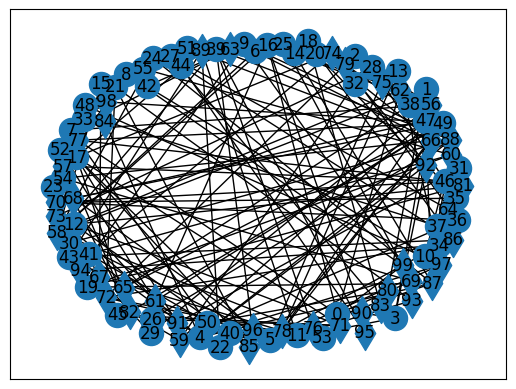

number of nodes: 100
number of edges: 168


In [ ]:
# node_number: number of nodes
# level: MOLECULAR, MODULE or ORGANELLE
# MODULE and ORGANELLE are not fully implemented yet!

# json file is written automatically
# please repeat if graph is not connected

build_network_layout(node_number=100, level=Level.MOLECULAR)